In [1]:
import collections
import functools
import os
import pathlib

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

/projects/b1196/envs/serniczek/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200
%config InlineBackend.figure_format = "retina"

In [3]:
def sanitize_name(name):
    return name.replace(' ', '_').replace('*', '').replace(';', '_and').replace('/', '_')

# Save & plot pseudobulk counts

We will use genes filterd by [this notebook](https://github.com/NUPulmonary/serniczek/blob/main/04b_geneformer/05a_gene_filtering_pseudobulk.ipynb) to preselect only consistently-expressed genes and thus increase power.

Pseudobulks are constructed by summing up genes in all cells from same sample–cell type pair.

We will use `Level_6` for cell types, consistent with the project.

We will save all pathogen groups together for each cell type, discarding the discard. And we will normalize all groups together on the DESeq2 side, before doing a comparison between 2 groups (as in best practice for DESeq2).

In [4]:
ROOT = pathlib.Path('/projects/b1196/ewa_group/serniczek/data')

In [5]:
BASE = ROOT / '05_pseudobulk/10_pathogen'

In [6]:
os.makedirs(BASE, exist_ok=True)

Filtered genes base. Directories there are `perturbation_groups`, within files by `cell_type`

In [7]:
GENES = ROOT / '04b_geneformer/attention/filtered_gene_lists'

In [8]:
adata = sc.read_h5ad(ROOT / '02b_integration/09_raw/09_raw.h5ad')

In [9]:
adata.shape

(2452841, 19488)

Number of cells to make a pseudobulk

In [10]:
PSEUDOBULK_CUTOFF = 50

In [11]:
METADATA_FIELDS = {
    'individual': 'sample',
    'Level_6': 'cell_type',
    'perturbation_groups': 'group',
    'Sex_genes': 'sex',
}

In [12]:
class CellTypeInfo:
    def __init__(self):
        self.genes = []
        self.pseudobulks = []
        self.n_cells = []
        self.metadata = []
        self.sample_info = []

In [13]:
%%time
cell_types = {}
for cell_type in adata.obs.Level_6.unique():
    info = CellTypeInfo()
    cell_types[cell_type] = info
    ct_clean = sanitize_name(cell_type)
    for perturbation_group in adata.obs.perturbation_groups.unique():
        if perturbation_group == 'discard':
            continue
        group_clean = sanitize_name(perturbation_group)

        # load genes
        # CSV file can be empty (like completely), then pandas will raise error when loading
        # it doesn't mean there are no cells
        try:
            genes = pd.read_csv(GENES / group_clean / f'{ct_clean}.csv', header=None).iloc[:, 1]
            info.genes.append(genes)
        except pd.errors.EmptyDataError:
            pass

        # compute pseudobulks
        idx = (
            adata.obs.Level_6.eq(cell_type) 
            & adata.obs.perturbation_groups.eq(perturbation_group)
        )
        for sample in adata.obs.individual[idx].unique():
            sample_idx = idx & adata.obs.individual.eq(sample)
            sample_row = adata.obs.loc[
                sample_idx, 
                list(METADATA_FIELDS.keys())
            ].head(1).rename(columns=METADATA_FIELDS)
            sample_row['n_cells'] = sample_idx.sum()
            info.sample_info.append(sample_row)
            if sample_idx.sum() < PSEUDOBULK_CUTOFF:
                continue
            info.pseudobulks.append(adata.X[sample_idx].sum(axis=0).A1)
            info.n_cells.append((adata.X[sample_idx] > 0).sum(axis=0).A1)
            info.metadata.append(sample_row)

CPU times: user 59.1 s, sys: 1 s, total: 1min
Wall time: 1min 1s


In [14]:
sample_df = []
for cell_type, info in cell_types.items():
    df = pd.concat(info.sample_info)
    counts = df.loc[
        df.n_cells.ge(PSEUDOBULK_CUTOFF)
    ].groupby('group').size().reset_index(name='count')
    counts['discarded'] = False
    counts_discarded = df.loc[
        df.n_cells.lt(PSEUDOBULK_CUTOFF)
    ].groupby('group').size().reset_index(name='count')
    counts_discarded['discarded'] = True
    counts = pd.concat([counts, counts_discarded])
    counts = counts.loc[counts.group.ne('discard')]
    counts['cell_type'] = cell_type
    sample_df.append(counts)
sample_df = pd.concat(sample_df)

In [15]:
sample_df.group = sample_df.group.cat.remove_unused_categories()

In [16]:
sample_df = sample_df.sort_values('cell_type')

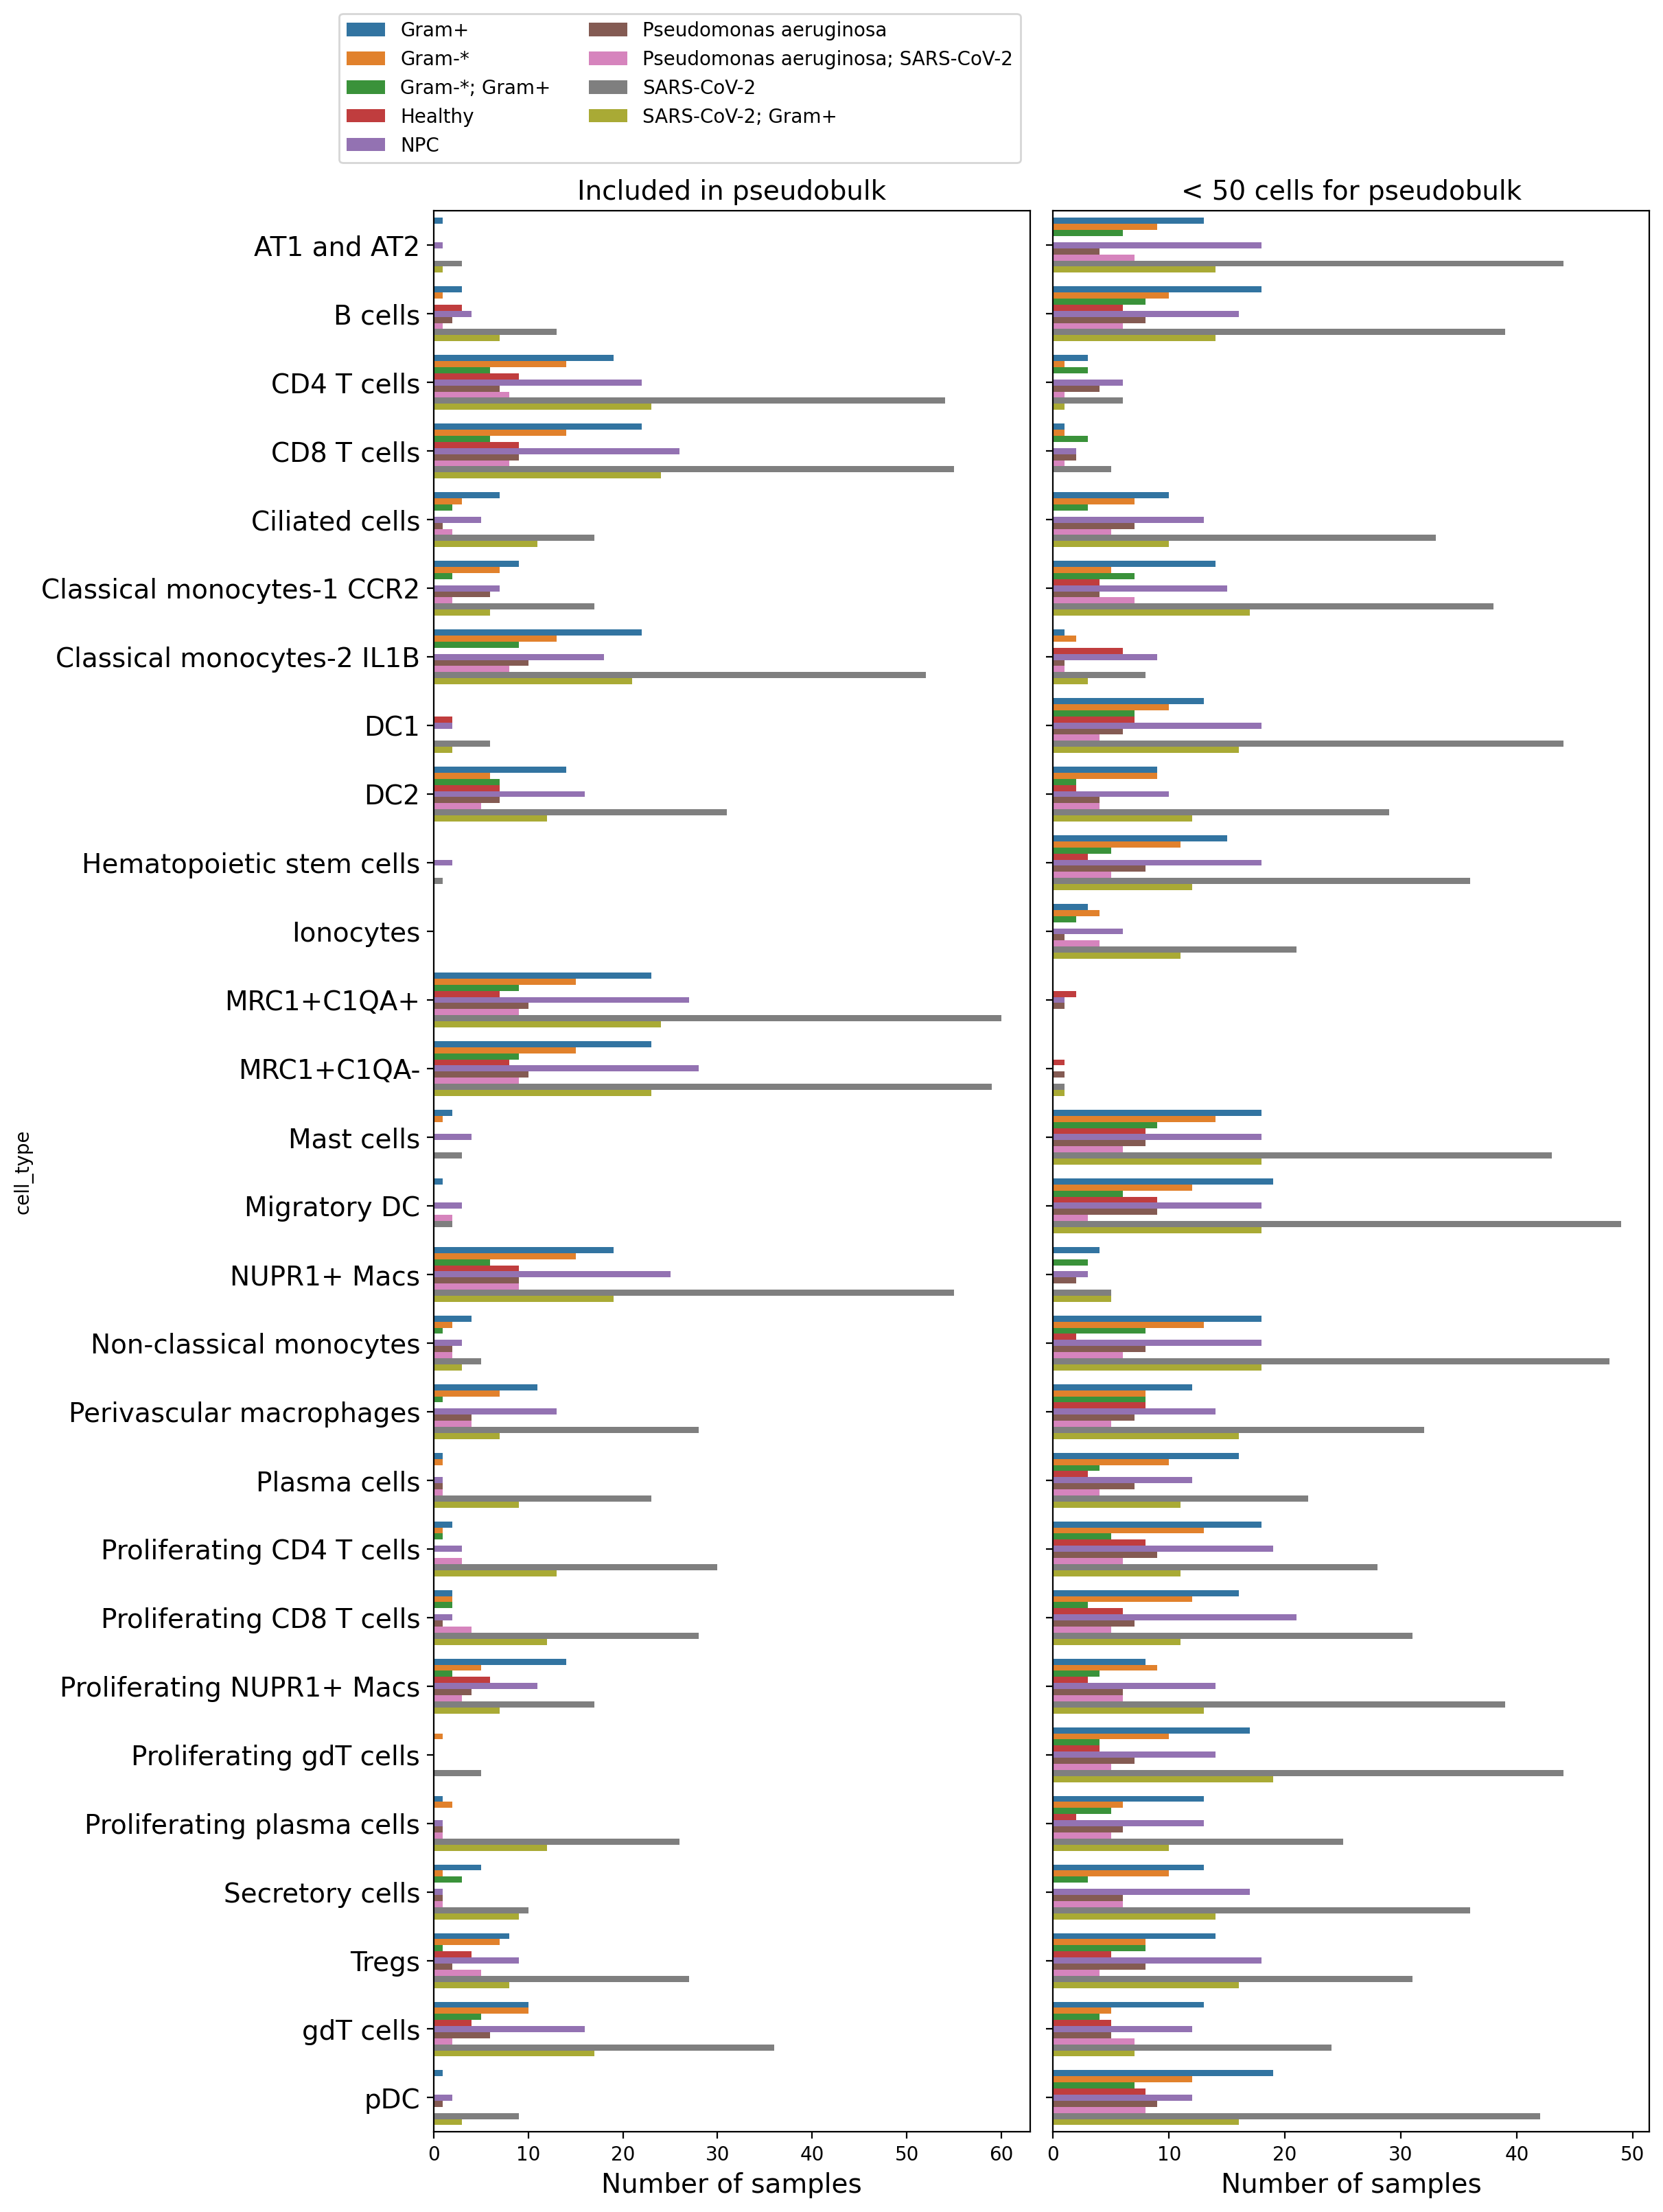

In [17]:
fig, axes = plt.subplots(
    figsize=(12, 16), 
    ncols=2, 
    constrained_layout=True, 
    sharey=True, 
    sharex=False
)
sns.barplot(
    data=sample_df.loc[~sample_df.discarded],
    y='cell_type',
    x='count',
    hue='group',
    ax=axes[0]
)
sns.barplot(
    data=sample_df.loc[sample_df.discarded],
    y='cell_type',
    x='count',
    hue='group',
    ax=axes[1]
)
axes[1].legend_.remove()
axes[0].legend(
    handles=axes[0].legend_.legend_handles,
    ncols=2,
    loc='lower right',
    bbox_to_anchor=(1, 1.02)
)
axes[0].tick_params(axis='y', labelsize=14)
axes[0].set_xlabel('Number of samples', size=14)
axes[1].set_xlabel('Number of samples', size=14)
axes[0].set_title('Included in pseudobulk', size=14)
axes[1].set_title('< 50 cells for pseudobulk', size=14)
fig.savefig('10_pathogen_pseudobulk_n_samples.pdf')

In [18]:
mt_idx = adata.var_names.str.startswith('MT-')
mt_pct_df = []
for cell_type, info in cell_types.items():
    # Some cell type have ZERO samples
    if not info.metadata:
        continue
    pseudobulk = np.vstack(info.pseudobulks)
    metadata = pd.concat(info.metadata).reset_index(drop=True)
    mt_pct = pseudobulk[:, mt_idx].sum(axis=1) / pseudobulk.sum(axis=1)
    mt_df = metadata.copy()
    mt_df['pct_mito'] = mt_pct * 100
    mt_pct_df.append(mt_df)
mt_pct_df = pd.concat(mt_pct_df, axis=0)

<Axes: xlabel='pct_mito', ylabel='cell_type'>

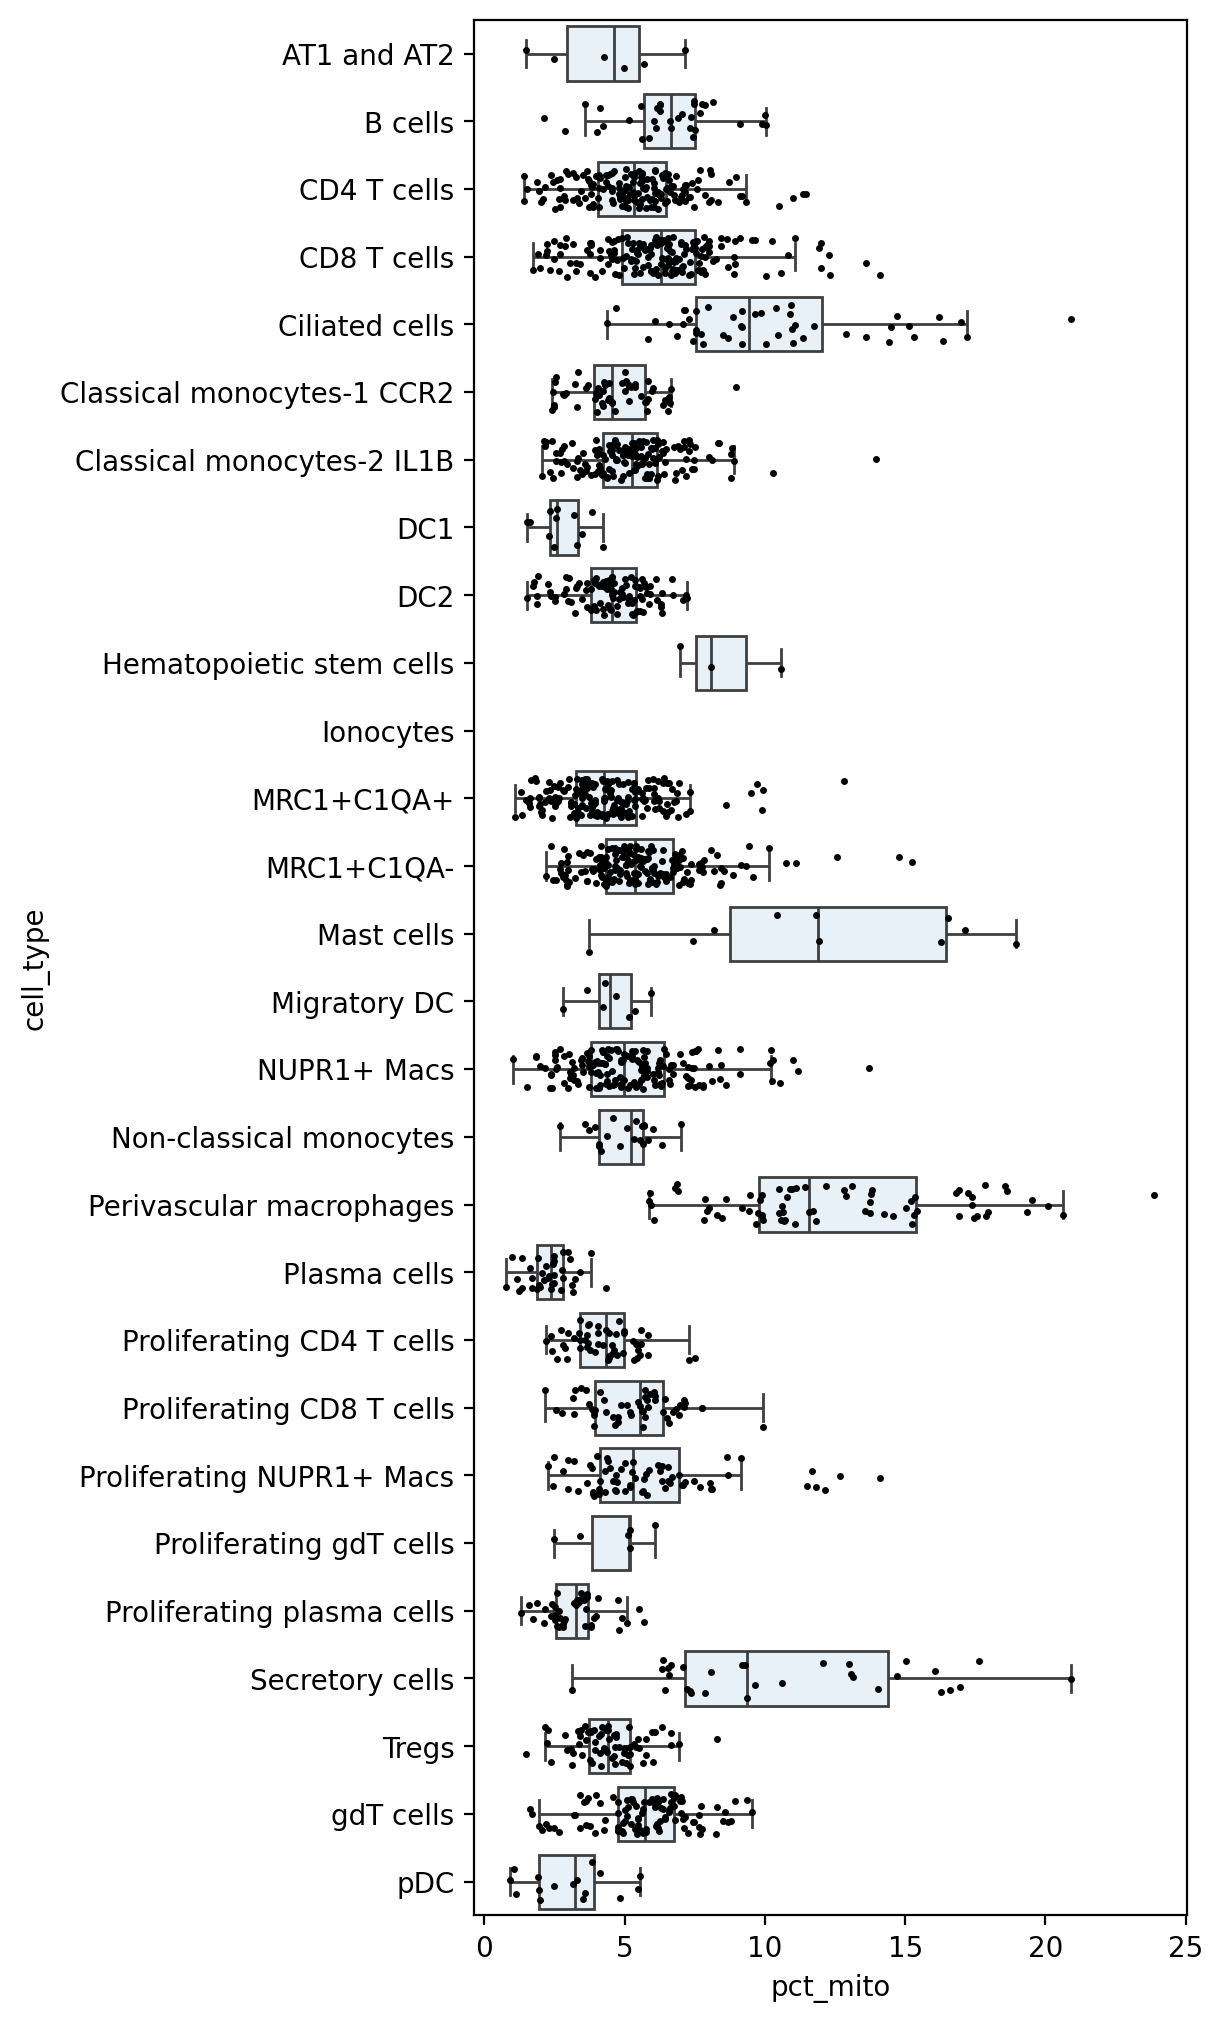

In [19]:
fig, ax = plt.subplots(figsize=(6, 10), constrained_layout=True)
sns.boxplot(
    data=mt_pct_df,
    orient='h',
    y='cell_type',
    x='pct_mito',
    # cut=0,
    ax=ax,
    showfliers=False,
    boxprops=dict(
        facecolor=('tab:blue', 0.1)
    )
)
sns.stripplot(
    data=mt_pct_df,
    orient='h',
    y='cell_type',
    x='pct_mito',
    size=2.5,
    color='k',
    ax=ax,
    jitter=0.3
)

In [20]:
for cell_type, info in cell_types.items():
    # Some cell type have ZERO samples
    if not info.metadata:
        continue
    genes = functools.reduce(np.union1d, info.genes)
    # Explicitly remove SARS-CoV-2 genes
    gene_idx = adata.var_names.isin(genes) & ~adata.var_names.str.startswith('SARS-CoV-2')
    gene_names = adata.var_names[gene_idx]
    pseudobulk = np.vstack(info.pseudobulks)[:, gene_idx]
    metadata = pd.concat(info.metadata).reset_index(drop=True)
    pseudobulk = pd.DataFrame(pseudobulk, columns=gene_names, index=metadata['sample']).T
    gene_cells = np.stack(info.n_cells)[:, gene_idx]
    gene_cells = pd.DataFrame(gene_cells, columns=gene_names, index=metadata['sample']).T

    ct_clean = sanitize_name(cell_type)
    path = BASE / ct_clean / 'data'
    os.makedirs(path, exist_ok=True)
    pseudobulk.to_csv(path / 'count.txt', sep='\t')
    gene_cells.to_csv(path / 'n_cells.txt', sep='\t')
    metadata.to_csv(path / 'meta.csv')